In [29]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report
import numpy as np

In [30]:
tf.__version__

'2.19.0'

In [31]:
train_dir = 'dataset_balanceado_final/train'
validation_dir = 'dataset_balanceado_final/validation'
test_dir = 'dataset_balanceado_final/test'

Definir batch_size e image_size

In [32]:
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = 150
BATCH_SIZE = 32

Training set -  É o conjunto de dados usado para treinar a rede

In [33]:
train_dataset = image_dataset_from_directory(
    train_dir, 
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical' 
)

Found 4276 files belonging to 7 classes.


Validation set - Usado para 'testar' o modelo durante o processo de procura da melhor combinação de hiperparâmetros.

In [34]:
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1420 files belonging to 7 classes.


Test set - Usado para testar o modelo depois do processo de treino

In [35]:
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

Found 1420 files belonging to 7 classes.


### Metricas para avaliar os modelos

In [36]:
# Utiliza uma função(do sckicit-learn) para avaliar o desempenho do modelo, indicando Métricas como: 
    # f1-score do modelo
    # accuracy do modelo
    # accuracy por classe 

from sklearn.metrics import classification_report
import numpy as np

def print_classification_metrics(model, dataset, phase_name):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    print(f"\n {phase_name}")
    print(classification_report(y_true, y_pred, digits=4))


# MODELO 2 (VGG16) 

## Feature Extraction 

### Data Augmentation 

In [37]:
from tensorflow import keras 
from keras import layers 
from keras.applications import VGG16 # Importa a arquitetura VGG16 pré-treinada do Keras.

# Data augmentation
data_augmentation_vgg16 = keras.Sequential([ 
    layers.RandomFlip("vertical"),# Aplica inversão vertical nas imagens.
    layers.RandomFlip("horizontal"), # Aplica inversão horizontal nas imagens
    layers.RandomTranslation(0.1, 0.2), 
    layers.RandomRotation(0.4), # Aplica rotação de 20% 
    #layers.RandomZoom(0.1)
    ]) # Aplica zoom de 20% 

# Carregar a base VGG16 pré-treinada
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) # Carrega o modelo VGG16 pré-treinado no ImageNet, sem a camada do topo
conv_base.trainable = False # Congela todas as camadas da VGG16, impedindo que os seus pesos sejam atualizados durante o treino (feature extraction).

# Usar data augmentation
inputs = layers.Input(shape=(150, 150, 3)) # Define a camada de entrada do novo modelo com o formato das imagens e 3 canais (RGB)
x = data_augmentation_vgg16(inputs) # Aplica as transformações de aumento de dados nas imagens de entrada.
x = keras.applications.vgg16.preprocess_input(x) # Aplica o pré-processamento específico da VGG16 
x = conv_base(x) # Passa as imagens (pré-processadas e aumentadas) através da base VGG16 congelada para extrair características.
x = layers.Flatten()(x) # Achata as características extraídas para um vetor 1D.
x = layers.Dense(256, activation='relu')(x) # Adiciona uma camada densa com 256 neurónios e ativação ReLU.
x = layers.Dropout(0.5)(x) # Aplica Dropout (50%) para regularização e prevenção de overfitting.
outputs = layers.Dense(7, activation='softmax')(x) # Adiciona a camada de saída densa com 7 neurónios (para 7 classes) e ativação Softmax

model_t = models.Model(inputs, outputs) # Cria o model_t

# Compilar e treinar (feature extraction)
model_t.compile( # Compila o modelo para configurar o processo de treino.
    loss='categorical_crossentropy', # Define a função de loss categorical crossentropy.
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), # Configura o otimizador Adam  learning_rate=1e-3) 
    metrics=['accuracy'] # Define 'accuracy' (precisão) como a métrica a ser monitorizada.
)

history_t = model_t.fit( # Treina o modelo.
    train_dataset, # Usa o conjunto de dados de treino.
    validation_data=validation_dataset, # Usa o conjunto de dados de validação para monitorizar o desempenho.
    epochs=15 # Treina o modelo por 10 épocas.
)

Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.3233 - loss: 5.1769 - val_accuracy: 0.4718 - val_loss: 1.4558
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.4248 - loss: 1.5484 - val_accuracy: 0.5134 - val_loss: 1.2832
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.4333 - loss: 1.4760 - val_accuracy: 0.5303 - val_loss: 1.2436
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.4524 - loss: 1.4186 - val_accuracy: 0.5824 - val_loss: 1.1935
Epoch 5/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.4836 - loss: 1.3557 - val_accuracy: 0.5577 - val_loss: 1.2682
Epoch 6/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.4890 - loss: 1.3777 - val_accuracy: 0.5880 - val_loss: 1.1366
Epoch 7/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.5043 - loss: 1.2932 - val_accuracy: 0.5866 - val_loss: 1.1227
Epoch 8/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.5086 - loss: 1

In [38]:
print_classification_metrics(model_t, test_dataset, "Modelo 2 : VGG16 (Feature Extraction com Augmentation)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

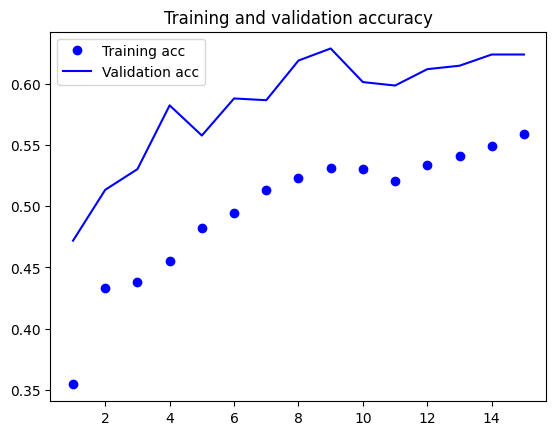

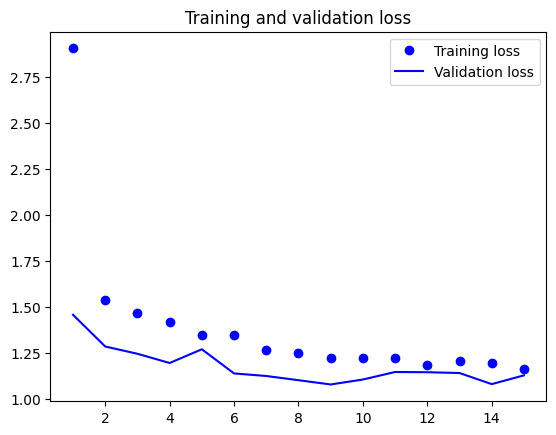

In [39]:
import matplotlib.pyplot as plt
accuracy = history_t.history['accuracy']
val_acc = history_t.history['val_accuracy']
loss = history_t.history['loss']
val_loss = history_t.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Durante a feature extraction, observa-se uma subida constante na acurácia de treino (0.35 para 0.56) e validação (0.47 para 0.62), com curvas próximas e paralelas. Esse padrão indica que o modelo está a aprender de forma gradual e equilibrada, com boa capacidade de generalização.

As perdas de treino e validação diminuem progressivamente, com valores bastante próximos (1.0–1.5), o que sugere que o modelo está a convergir bem e sem sinais de overfitting nesta etapa inicial.

## Fine Tuning

In [40]:
# Descongelar parte da VGG16 (últimas camadas)
conv_base.trainable = True
for layer in conv_base.layers[:-4]:  # Descongelar as ultimas -8
    layer.trainable = False # manter as primeiras camadas congeladas

# Recompilar o modelo com learning rate menor
model_t.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# Treinar novamente
history_t = model_t.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=15 
)

Epoch 1/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.5550 - loss: 1.1736 - val_accuracy: 0.6535 - val_loss: 1.0091
Epoch 2/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.5877 - loss: 1.0485 - val_accuracy: 0.6613 - val_loss: 1.0168
Epoch 3/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.6067 - loss: 1.0131 - val_accuracy: 0.6493 - val_loss: 1.0757
Epoch 4/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.6187 - loss: 0.9626 - val_accuracy: 0.6634 - val_loss: 1.0168
Epoch 5/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.6246 - loss: 0.9596 - val_accuracy: 0.6634 - val_loss: 1.0332
Epoch 6/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.6427 - loss: 0.9297 - val_accuracy: 0.6690 - val_loss: 0.9782
Epoch 7/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.6357 - loss: 0.9442 - val_accuracy: 0.6908 - val_loss: 0.9736
Epoch 8/15
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - accuracy: 0.6476 - loss: 0

In [41]:
print_classification_metrics(model_t, test_dataset, "Modelo 2 : Fine-tuning")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

2025-06-12 01:51:08.115895: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Curvas de Loss e de Accuracy

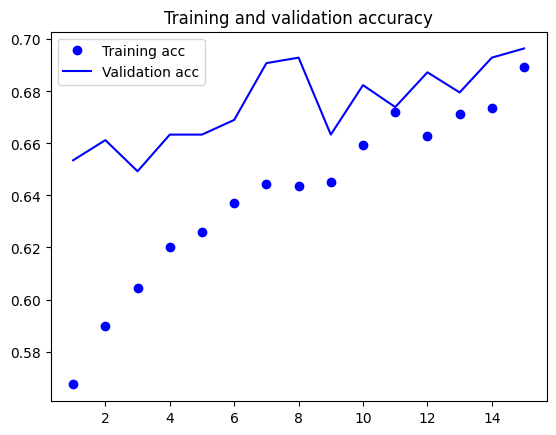

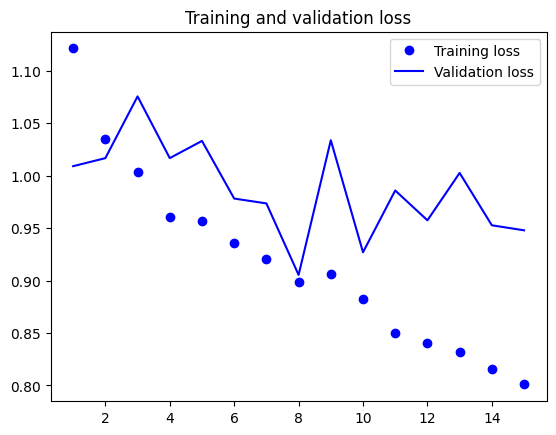

In [42]:
import matplotlib.pyplot as plt
accuracy = history_t.history['accuracy']
val_acc = history_t.history['val_accuracy']
loss = history_t.history['loss']
val_loss = history_t.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

No fine-tuning, as acurácias de treino e validação aumentam de forma consistente, alcançando cerca de 0.69. As curvas estão próximas, o que indica que o modelo está a melhorar seu desempenho sem sinais evidentes de overfitting, o que reflete um ajuste mais equilibrado.

As perdas de treino e validação diminuem ao longo das épocas. Apesar de alguma oscilação na loss de validação, ambas as curvas seguem uma tendência de queda e permanecem próximas, sugerindo convergência estável e boa generalização durante o tuning.

### Matriz de Confusão

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

<Figure size 1000x800 with 0 Axes>

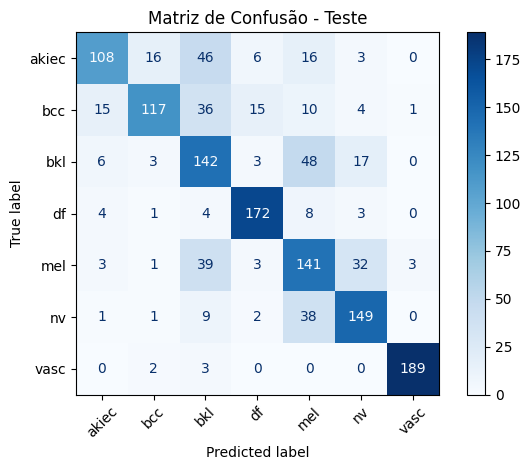

: 

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obter predições no test_dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model_t.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

class_names = test_dataset.class_names  

# Criar e mostrar a matriz de confusão
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45, values_format='d')
plt.title("Matriz de Confusão - Teste")
plt.tight_layout()
plt.show()

O modelo apresenta bom desempenho geral, com alta taxa de acerto nas classes ‘df’, ‘nv’ e ‘vasc’, que foram corretamente classificadas na maioria dos casos. No entanto, há confusão significativa entre as classes ‘akiec’, ‘bcc’ e ‘bkl’, o que sugere que o modelo ainda tem dificuldade em distinguir essas lesões, possivelmente devido à semelhança visual entre elas.

## Salvar o Modelo

In [44]:
model_t.save("modelT_3A_com_data_aug_adam_cat_cross_best_acc.keras")

## Definir a Função para obter Computed Features

In [45]:
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input

def extract_computed_features(conv_base, dataset, augment_layer=None):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        # Aplica data augmentation se fornecido
        if augment_layer:
            images = augment_layer(images)
        
        # Pre-processamento obrigatório para VGG16
        preprocessed = preprocess_input(images)
        
        # Extrair as computed features
        features = conv_base.predict(preprocessed)
        
        all_features.append(features)
        all_labels.append(labels)

    # Junta tudo num único array
    features_array = np.concatenate(all_features)
    labels_array = np.concatenate(all_labels)

    return features_array, labels_array


Usar a funçao "extract_computed_features"

In [46]:
train_features, train_labels = extract_computed_features(conv_base, train_dataset, augment_layer=data_augmentation_vgg16)
val_features, val_labels = extract_computed_features(conv_base, validation_dataset, augment_layer=None)
test_features, test_labels = extract_computed_features(conv_base, test_dataset, augment_layer=None)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Salvar as Computed Features

In [47]:
from numpy import save

save("modelt_3A_train_features.npy", train_features)
save("modelt_3A_train_labels.npy", train_labels)

save("modelt_3A_val_features.npy", val_features)
save("modelt_3A_val_labels.npy", val_labels)

save("modelt_3A_test_features.npy", test_features)
save("modelt_3A_test_labels.npy", test_labels)
